# Embeddings

Embeddings are vectorial representations of text that capture the semantic meaning of paragraphs through their position in a high dimensional vector space. Mistral Embeddings API offers cutting-edge, state-of-the-art embeddings for text, which can be used for many NLP tasks. In this guide, we will cover the fundamentals of the Mistral embeddings API, including how to measure the distance between text embeddings, and explore its main use cases:  clustering and classification. 

## Mistral Embeddings API 
To generate text embeddings using Mistral’s embeddings API, we can make a request to the API endpoint and specify the embedding model `mistral-embed`, along with providing a list of input text. The API will then return the corresponding embeddings as numerical vectors, which can be used for further analysis or processing in NLP applications.



In [ ]:
!pip install mistralai==0.0.12 seaborn numpy scikit-learn

In [1]:
from mistralai.client import MistralClient

client = MistralClient(api_key="TYPE YOUR API KEY")

embeddings_batch_response = client.embeddings(
    model="mistral-embed",
    input=["Embed this sentence.", "As well as this one."],
  )


The output is a EmbeddingResponse object with the embeddings and the token usage information. 

```
EmbeddingResponse(id='eb4c2c739780415bb3af4e47580318cc', object='list', data=[EmbeddingObject(object='embedding', embedding=[-0.0165863037109375,...], index=0), EmbeddingObject(object='embedding', embedding=[-0.0234222412109375,...], index=1)], model='mistral-embed', usage=UsageInfo(prompt_tokens=15, total_tokens=15, completion_tokens=0))

```
Let’s take a look of the length of the first embedding:


In [2]:
len(embeddings_batch_response.data[0].embedding)

1024

It returns 1024, which means that our embedding dimension is 1024. The `mistral-embed` model generates embedding vectors of dimension 1024 for each text string, regardless of the text length.  It’s worth noting that while higher dimensional embeddings can better capture text information and improve the performance of NLP tasks, they may require more computational resources for hosting and inference, and may result in increased latency and memory usage for storing and processing these embeddings. This trade-off between performance and computational resources should be considered when designing NLP systems that rely on text embeddings.

### Distance measures

In the realm of text embeddings, texts with similar meanings or context tend to be located in closer proximity to each other within this space, as measured by the distance between their vectors. This is due to the fact that the model has learned to group semantically related texts together during the training process. 

Let’s take a look at a simple example. To simplify working with text embeddings, we can wrap the embedding API in this function:


In [3]:
from sklearn.metrics.pairwise import euclidean_distances

def get_text_embedding(input):
    embeddings_batch_response = client.embeddings(
          model="mistral-embed",
          input=input
      )
    return embeddings_batch_response.data[0].embedding

Suppose we have two sentences: one about cats and the other about books.  We want to find how similar each sentence is to the reference sentence "Books are mirrors: You only see in them what you already have inside you". We can see that the distance between the reference sentence embeddings and the book sentence embeddings is smaller than the distance between the reference sentence embeddings and the cat sentence embeddings. 


In [4]:
sentences = [
    "A home without a cat — and a well-fed, well-petted and properly revered cat — may be a perfect home, perhaps, but how can it prove title?",
    "I think books are like people, in the sense that they’ll turn up in your life when you most need them"
]
embeddings = [get_text_embedding(t) for t in sentences]

In [5]:
reference_sentence = "Books are mirrors: You only see in them what you already have inside you"
reference_embedding = get_text_embedding(reference_sentence)

In [6]:
for t, e in zip(sentences, embeddings):
    distance = euclidean_distances([e], [reference_embedding])
    print(t, distance)

A home without a cat — and a well-fed, well-petted and properly revered cat — may be a perfect home, perhaps, but how can it prove title? [[0.80094257]]
I think books are like people, in the sense that they’ll turn up in your life when you most need them [[0.58162089]]


In our example above, we used the Euclidean distance to measure the distance between embedding vectors (note that since Mistral embeddings are norm 1, cosine similarity, dot product or Euclidean distance are all equivalent).

### Paraphrase detection

Another potential use case is paraphrase detection. In this simple example, we have a list of three sentences, and we would like to find out if any of the two sentences are paraphrases of each other. If the distance between two sentence embeddings is small, it suggests that the two sentences are semantically similar and could be potential paraphrases. 

Result suggests that the first two sentences are semantically similar and could be potential paraphrases, whereas the third sentence is more different. This is just a super simple example. But this approach can be extended to more complex situations in real-world applications, such as detecting paraphrases in social media posts, news articles, or customer reviews.



In [7]:
sentences = [
    'Have a safe happy Memorial Day weekend everyone',
    'To all our friends at Whatsit Productions Films enjoy a safe happy Memorial Day weekend',
    'Where can I find the best cheese?'
]

In [8]:
sentence_embeddings = [get_text_embedding(t) for t in sentences]

In [9]:
import itertools

sentence_embeddings_pairs = list(itertools.combinations(sentence_embeddings, 2))
sentence_pairs = list(itertools.combinations(sentences, 2))

In [10]:
for s, e in zip(sentence_pairs, sentence_embeddings_pairs):
    print(s, euclidean_distances([e[0]], [e[1]]))

('Have a safe happy Memorial Day weekend everyone', 'To all our friends at Whatsit Productions Films enjoy a safe happy Memorial Day weekend') [[0.54326686]]
('Have a safe happy Memorial Day weekend everyone', 'Where can I find the best cheese?') [[0.92573978]]
('To all our friends at Whatsit Productions Films enjoy a safe happy Memorial Day weekend', 'Where can I find the best cheese?') [[0.9114184]]


### Batch processing 

The Mistral Embeddings API is designed to process text in batches for improved efficiency and speed. In this example, we will demonstrate this by loading the Symptom2Disease dataset from [Kaggle](https://www.kaggle.com/datasets/niyarrbarman/symptom2disease), which contains 1200 rows with two columns: "label" and "text". The "label" column indicates the disease category, while the "text" column describes the symptoms associated with that disease. 

We wrote a function `get_embeddings_by_chunks` that splits data into chunks and then sends each chunk to the Mistral embedding API to get the embeddings. Then we saved the embeddings as a new column in the dataframe. Note that the Mistral Embeddings API will provide auto-chunking in the future, so that users don’t need to manually split the data into chunks before sending it to the API. 


In [11]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/mistralai/cookbook/main/data/Symptom2Disease.csv", index_col=0)

In [12]:
def get_embeddings_by_chunks(data, chunk_size):
    chunks = [data[x:x+chunk_size] for x in range(0, len(data), chunk_size)]
    embeddings_response = [client.embeddings(model="mistral-embed", input=c) for c in chunks]
    embeddings = []
    for i in range(len(embeddings_response)):
        for d in embeddings_response[i].data:
            embeddings.append(d.embedding)
    return embeddings

In [13]:
df['embeddings'] = get_embeddings_by_chunks(df['text'].tolist(), 50)

In [14]:
df.head()

,label,text,embeddings
0,Psoriasis,I have been experiencing a skin rash on my arm...,"[-0.036102294921875, 0.041351318359375, 0.0734..."
1,Psoriasis,"My skin has been peeling, especially on my kne...","[-0.05364990234375, 0.05224609375, 0.073791503..."
2,Psoriasis,I have been experiencing joint pain in my fing...,"[-0.035400390625, 0.026275634765625, 0.0360107..."
3,Psoriasis,"There is a silver like dusting on my skin, esp...","[-0.035980224609375, 0.057037353515625, 0.0528..."
4,Psoriasis,"My nails have small dents or pits in them, and...","[-0.02471923828125, 0.039337158203125, 0.04772..."


## t-SNE embeddings visulization 

We mentioned previously that our embeddings have 1024 dimensions, which makes them impossible to visualize directly. Thus, in order to visualize our embeddings, we can use a dimensionality reduction technique such as t-SNE to project our embeddings into a lower-dimensional space that is easier to visualize. 

In this example, we transform our embeddings to 2 dimensions and create a 2D scatter plot showing the relationships among embeddings of different diseases. 


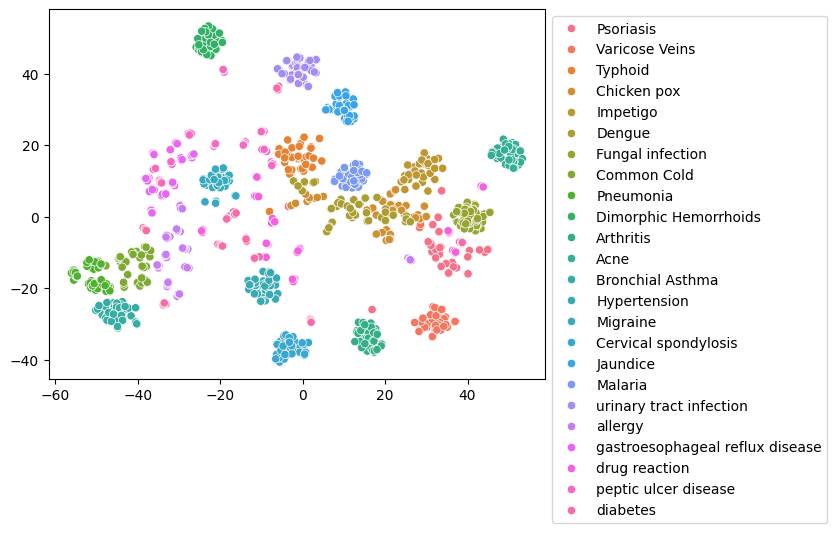

In [15]:
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np


tsne = TSNE(n_components=2, random_state=0).fit_transform(np.array(df['embeddings'].to_list()))
ax = sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=np.array(df['label'].to_list()))
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))


#### Comparison with fasttext 

We can compare it with fastText, a popular open-source embeddings model. However, when examining the t-SNE embeddings plot, we notice that fastText embeddings fail to create clear separations between data points with matching labels.


In [ ]:
!pip install fasttext

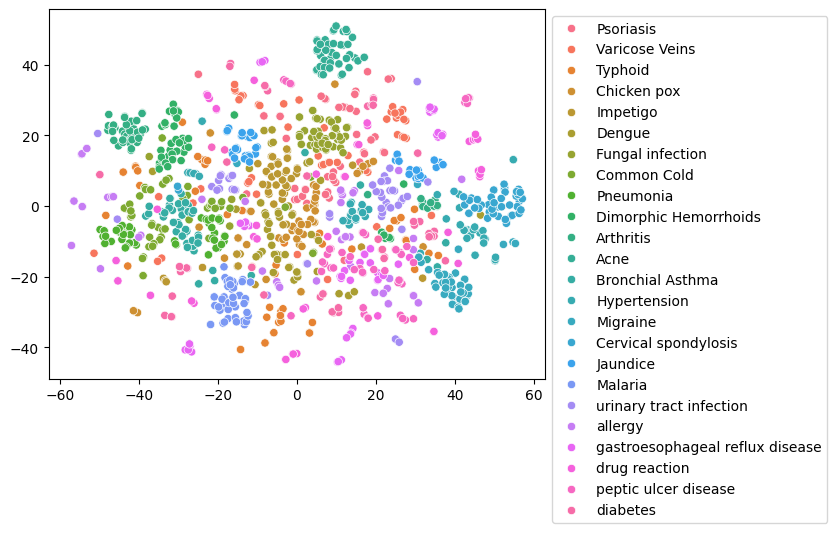

In [16]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')

df['fasttext_embeddings'] = df['text'].apply(lambda x: ft.get_word_vector(x).tolist())

tsne = TSNE(n_components=2, random_state=0).fit_transform(np.array(df['fasttext_embeddings'].to_list()))
ax = sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=np.array(df['label'].to_list()))
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))

## Classification

Text embeddings can be used as input features in machine learning models, such as classification and clustering. In this example, we use a classification model to predict the disease labels from the embeddings of disease description text. 



In [17]:
# Create a train / test split

from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(df['embeddings'], df["label"],test_size=0.2)

In [18]:
# Normalize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x.to_list())
test_x = scaler.transform(test_x.to_list())

In [19]:
# Train a classifier and compute the test accuracy

from sklearn.linear_model import LogisticRegression

# For a real problem, C should be properly cross validated and the confusion matrix analyzed
clf = LogisticRegression(random_state=0, C=1.0, max_iter=500).fit(train_x, train_y.to_list()) 

# you can also try the sag algorithm:
# clf = LogisticRegression(random_state=0, C=1.0, max_iter=1000, solver='sag').fit(train_x, train_y)

print(f"Precision: {100*np.mean(clf.predict(test_x) == test_y.to_list()):.2f}%")

Precision: 98.75%


In [20]:
# Classify a single example
text = "I've been experiencing frequent headaches and vision problems."
clf.predict([get_text_embedding(text)]).item()

'Migraine'

#### Comparison with fasttext 
Additionally, let’s take a look at the performance using fastText embeddings in this classification task. It appears that the classification model achieves better performance with Mistral embedding models as compared to using fastText embeddings.


In [21]:
# Create a train / test split
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df['fasttext_embeddings'], df["label"],test_size=0.2)
# Normalize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x.to_list())
test_x = scaler.transform(test_x.to_list())
# Train a classifier and compute the test accuracy
from sklearn.linear_model import LogisticRegression
# For a real problem, C should be properly cross validated and the confusion matrix analyzed
clf = LogisticRegression(random_state=0, C=1.0, max_iter=500).fit(train_x, train_y.to_list()) 
# you can also try the sag algorithm:
# clf = LogisticRegression(random_state=0, C=1.0, max_iter=1000, solver='sag').fit(train_x, train_y)
print(f"Precision: {100*np.mean(clf.predict(test_x) == test_y.to_list()):.2f}%")

Precision: 86.25%


## Clustering

What if we don’t have disease labels? One approach to gain insights from the data is through clustering. Clustering is an unsupervised machine learning technique that groups similar data points together based on their similarity with respect to certain features. In the context of text embeddings, we can use the distance between each embedding as a measure of similarity, and group together data points with embeddings that are close to each other in the high-dimensional space. 

Since we already know there are 24 clusters, let’s use the K-means clustering with 24 clusters. Then we can inspect a few examples and verify whether the examples in a single cluster are similar to one another. For example, take a look at the first three rows of cluster 23. We can see that they look very similar in terms of symptoms. 



In [22]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=24, max_iter=1000)
model.fit(df['embeddings'].to_list())
df["cluster"] = model.labels_

In [23]:
print(*df[df.cluster==23].text.head(3), sep='\n')

I have been feeling extremely tired and weak, and I've also been coughing a lot with difficulty breathing. My fever is very high, and I'm producing a lot of mucus when I cough.
I've got a cough that won't go away, and I'm exhausted. I've been coughing up thick mucous and my fever is also pretty high.
I have a persistent cough and have been feeling quite fatigued. My fever is through the roof, and I'm having trouble breathing. When I cough, I also cough up a lot of mucous.


## Retrieval 

Our embedding model excels in retrieval tasks, as it is trained with retrieval in mind. Embeddings are also incredibly helpful in implementing retrieval-augmented generation (RAG) systems, which use retrieved relevant information from a knowledge base to generate responses. At a high-level, we embed a knowledge base, whether it is a local directory, text files, or internal wikis, into text embeddings and store them in a vector database. Then, based on the user's query, we retrieve the most similar embeddings, which represent the relevant information from the knowledge base. Finally, we feed these relevant embeddings to a large language model to generate a response that is tailored to the user's query and context. If you are interested in learning more about how RAG systems work and how to implement a basic RAG, check out our [previous guide](https://github.com/mistralai/cookbook/blob/main/basic_RAG.ipynb) on this topic. 
